In [1]:
import mysql.connector
from mysql.connector import Error
import config

In [2]:
import pandas as pd
import seaborn as sns

# Database Connection

In [3]:
connection = None
try:
    connection = mysql.connector.connect(
        host=config.HOST,
        user=config.USER,
        passwd=config.PW,
        database=config.DB_NAME
    )
    print("MySQL Database connection successful")
except Error as err:
    print(f"Error: '{err}'")

MySQL Database connection successful


# Read Tables

In [4]:
def read_table(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
    except Error as err:
        print(f"Error: '{err}'")
    return result

In [9]:
# Table: hand
query = "SELECT * FROM hand;"
hands = read_table(connection, query)

hand_columns = ['hand_id', 'datetime', 'button', 'small_blind', 'big_blind', 'ante', 'flop_1', 'flop_2', 'flop_3', 'turn', 'river', 'total_pot', 'rake', 'is_showdown']
hand_df = pd.DataFrame(hands, columns=hand_columns)
hand_df.set_index('hand_id')

,datetime,button,small_blind,big_blind,ante,flop_1,flop_2,flop_3,turn,river,total_pot,rake,is_showdown
hand_id,,,,,,,,,,,,,
231630431940,2021-11-22 22:21:24,1,0.05,0.1,0.0,None,None,None,None,None,0.10,0.00,0
231630431945,2021-11-22 22:21:24,1,0.05,0.1,0.0,9c,3d,3s,5d,Kd,2.87,0.13,0
231630434349,2021-11-22 22:21:36,1,0.05,0.1,0.0,None,None,None,None,None,0.25,0.00,0
231630434749,2021-11-22 22:21:38,1,0.05,0.1,0.0,2h,8h,4c,Qd,None,0.72,0.03,0
231630435339,2021-11-22 22:21:41,1,0.05,0.1,0.0,Ks,Js,Kh,8c,4c,1.61,0.07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250377030460,2024-05-07 16:27:35,1,0.05,0.1,0.0,5c,Qd,2s,None,None,0.75,0.03,0
250377032672,2024-05-07 16:27:41,1,0.05,0.1,0.0,None,None,None,None,None,0.10,0.00,0
250377034076,2024-05-07 16:27:45,1,0.05,0.1,0.0,None,None,None,None,None,0.55,0.00,0


In [10]:
# Table: participant
query = "SELECT * FROM participant;"
participants = read_table(connection, query)
    
participant_columns = ['name', 'hand_id', 'starting_stack', 'ending_stack']
participant_df = pd.DataFrame(participants, columns=participant_columns)

In [25]:
# Table: action
query = "SELECT * FROM action;"
actions = read_table(connection, query)
    
action_columns = ['hand_id', 'action_number', 'street', 'player_name', 'type', 'size']
action_df = pd.DataFrame(actions, columns=action_columns)

In [12]:
# Table: cards
query = "SELECT * FROM cards;"
cards = read_table(connection, query)
    
cards_columns = ['hand_id', 'player_name', 'card_1', 'card_2']
cards_df = pd.DataFrame(cards, columns=cards_columns)

# New Columns

In [13]:
# Generate general hand combo. Ex: AKo is the general type of AcKs
def get_general_combo(card_1, card_2):
    card_values = 'AKQJT98765432'
    if card_1[0] == card_2[0]:
        # Pocket pair
        return card_1[0] + card_2[0]
    value_1 = card_values.index(card_1[0])
    value_2 = card_values.index(card_2[0])
    if value_1 > value_2:
        high_card = card_values[value_2]
        low_card = card_values[value_1]
    else:
        high_card = card_values[value_1]
        low_card = card_values[value_2]
    if card_1[1] == card_2[1]:
        # Suited
        return f'{high_card}{low_card}s'
    return f'{high_card}{low_card}o'

In [14]:
# Add general hand combo to cards data
cards_df['combo'] = cards_df.apply(lambda x: get_general_combo(x['card_1'], x['card_2']), axis=1)

In [15]:
# Add PFR to hand
def get_pfr_name(hand_id, action_df):
    df = action_df[action_df['hand_id'] == hand_id]
    df = df.loc[(df['type'] == 'R') & (df['street'] == 'preflop')]
    if df.empty:
        return None
    return df.iloc[-1]['player_name']

In [16]:
# If no way to speed this up, I should do it once and stock it in the db after ***
hand_df['pfr'] = hand_df.apply(lambda x: get_pfr_name(x['hand_id'], action_df), axis=1)

In [17]:
# Add hero line to hand
def get_player_line(hand_id, action_df, player_name):
    df = action_df.loc[(action_df['hand_id'] == hand_id) & (action_df['player_name'] == player_name)]
    line_df = df.groupby('street').apply(lambda x: x['type'].values, include_groups=False)
    line = ''
    if 'preflop' in line_df.index:
        for action_type in line_df.loc['preflop']:
            line += action_type
    if 'flop' in line_df.index:
        line += ','
        for action_type in line_df.loc['flop']:
            line += action_type
    if 'turn' in line_df.index:
        line += ','
        for action_type in line_df.loc['turn']:
            line += action_type
    if 'river' in line_df.index:
        line += ','
        for action_type in line_df.loc['river']:
            line += action_type
    return line

In [18]:
hand_df['hero_line'] = hand_df.apply(lambda x: get_player_line(x['hand_id'], action_df, 'gablabzmoney'), axis=1)

In [36]:
# Note: number_of_raises = 2 in 3bet pot, 3 in 4bet pot, etc.
def get_number_of_preflop_raises(hand_id, action_df):
    df = action_df.loc[(action_df['hand_id'] == hand_id) & (action_df['street'] == 'preflop') & (action_df['type'] == 'R')]
    return df.shape[0]

In [45]:
hand_df['number_of_raises'] = hand_df.apply(lambda x: get_number_of_preflop_raises(x['hand_id'], action_df), axis=1)
print(hand_df)

           hand_id            datetime  button  small_blind  big_blind  ante  \
0     231630431940 2021-11-22 22:21:24       1         0.05        0.1   0.0   
1     231630431945 2021-11-22 22:21:24       1         0.05        0.1   0.0   
2     231630434349 2021-11-22 22:21:36       1         0.05        0.1   0.0   
3     231630434749 2021-11-22 22:21:38       1         0.05        0.1   0.0   
4     231630435339 2021-11-22 22:21:41       1         0.05        0.1   0.0   
...            ...                 ...     ...          ...        ...   ...   
8418  250377030460 2024-05-07 16:27:35       1         0.05        0.1   0.0   
8419  250377032672 2024-05-07 16:27:41       1         0.05        0.1   0.0   
8420  250377034076 2024-05-07 16:27:45       1         0.05        0.1   0.0   
8421  250377039582 2024-05-07 16:28:01       1         0.05        0.1   0.0   
8422  250377050300 2024-05-07 16:28:32       1         0.05        0.1   0.0   

     flop_1 flop_2 flop_3  turn river  

In [19]:
hand_df

,hand_id,datetime,button,small_blind,big_blind,ante,flop_1,flop_2,flop_3,turn,river,total_pot,rake,is_showdown,pfr,hero_line
0,231630431940,2021-11-22 22:21:24,1,0.05,0.1,0.0,None,None,None,None,None,0.10,0.00,0,None,
1,231630431945,2021-11-22 22:21:24,1,0.05,0.1,0.0,9c,3d,3s,5d,Kd,2.87,0.13,0,abacu20,F
2,231630434349,2021-11-22 22:21:36,1,0.05,0.1,0.0,None,None,None,None,None,0.25,0.00,0,rayban07,F
3,231630434749,2021-11-22 22:21:38,1,0.05,0.1,0.0,2h,8h,4c,Qd,None,0.72,0.03,0,gablabzmoney,"R,X,B"
4,231630435339,2021-11-22 22:21:41,1,0.05,0.1,0.0,Ks,Js,Kh,8c,4c,1.61,0.07,1,ImMikeRoss,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8418,250377030460,2024-05-07 16:27:35,1,0.05,0.1,0.0,5c,Qd,2s,None,None,0.75,0.03,0,samslik,"C,B"
8419,250377032672,2024-05-07 16:27:41,1,0.05,0.1,0.0,None,None,None,None,None,0.10,0.00,0,None,F
8420,250377034076,2024-05-07 16:27:45,1,0.05,0.1,0.0,None,None,None,None,None,0.55,0.00,0,CaJe94,F
8421,250377039582,2024-05-07 16:28:01,1,0.05,0.1,0.0,None,None,None,None,None,0.20,0.00,0,gablabzmoney,R


# Filters

In [20]:
def filter_by_date(df, from_dt=None, to_dt=None):
    if from_dt:
        df = df[df['datetime'] > from_dt]
    if to_dt:
        df = df[df['datetime'] < to_dt]
    return df

# Winnings Graphs

In [13]:
def winnings_df(hand_df, participant_df, hero_name, big_blind=None):
    if big_blind:
        hand_df = hand_df[hand_df['big_blind'] == big_blind]
    player_df = participant_df[participant_df['name'] == hero_name]
    df = pd.merge(hand_df, player_df, on="hand_id")
    total = 0
    total_series = []
    for index, row in df.iterrows():
        total += row['ending_stack'] - row['starting_stack']
        total_series.append(total)
    df['winnings'] = pd.Series(total_series)
    return df

In [14]:
sns.set_theme()

[Text(0.5, 0, 'Hand'),
 Text(0, 0.5, 'Winnings in $'),
 Text(0.5, 1.0, 'Total Winnings')]

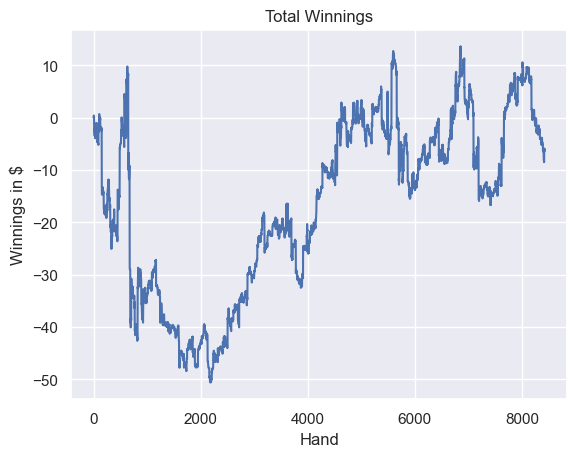

In [15]:
total_winnings_df = winnings_df(hand_df, participant_df, 'gablabzmoney')
graph = sns.lineplot(x=total_winnings_df.index, y="winnings", data=total_winnings_df)
graph.set(xlabel='Hand', ylabel='Winnings in $', title='Total Winnings')

[Text(0.5, 0, 'Hand'),
 Text(0, 0.5, 'Winnings in $'),
 Text(0.5, 1.0, 'Winnings 10NL')]

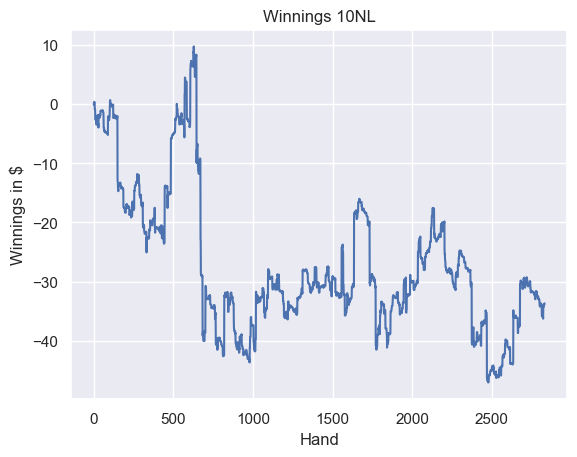

In [16]:
NL10_winnings_df = winnings_df(hand_df, participant_df, 'gablabzmoney', big_blind=0.1)
graph = sns.lineplot(x=NL10_winnings_df.index, y="winnings", data=NL10_winnings_df)
graph.set(xlabel='Hand', ylabel='Winnings in $', title='Winnings 10NL')

# Hand Heatmap

In [17]:
def to_cell_number(combo):
    card_values = 'AKQJT98765432'
    if combo[0] == combo[1]:
        return card_values.index(combo[0]), card_values.index(combo[1])
    elif combo[2] == 's':
        return card_values.index(combo[0]), card_values.index(combo[1])
    else:
        return card_values.index(combo[1]), card_values.index(combo[0])

In [54]:
card_values = 'AKQJT98765432'
matrix = []
for i, value1 in enumerate(card_values):
    row = []
    for j, value2 in enumerate(card_values):
        if i == j:
            row.append(value1 + value2)
        elif i < j:
            row.append(value1 + value2 + 's')
        else:
            row.append(value2 + value1 + 'o')
    matrix.append(row)
columns = [value for value in card_values]
index = [value for value in card_values]
combos_df = pd.DataFrame(matrix, index=index, columns=columns)
combos_df

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,AA,AKs,AQs,AJs,ATs,A9s,A8s,A7s,A6s,A5s,A4s,A3s,A2s
K,AKo,KK,KQs,KJs,KTs,K9s,K8s,K7s,K6s,K5s,K4s,K3s,K2s
Q,AQo,KQo,QQ,QJs,QTs,Q9s,Q8s,Q7s,Q6s,Q5s,Q4s,Q3s,Q2s
J,AJo,KJo,QJo,JJ,JTs,J9s,J8s,J7s,J6s,J5s,J4s,J3s,J2s
T,ATo,KTo,QTo,JTo,TT,T9s,T8s,T7s,T6s,T5s,T4s,T3s,T2s
9,A9o,K9o,Q9o,J9o,T9o,99,98s,97s,96s,95s,94s,93s,92s
8,A8o,K8o,Q8o,J8o,T8o,98o,88,87s,86s,85s,84s,83s,82s
7,A7o,K7o,Q7o,J7o,T7o,97o,87o,77,76s,75s,74s,73s,72s
6,A6o,K6o,Q6o,J6o,T6o,96o,86o,76o,66,65s,64s,63s,62s
5,A5o,K5o,Q5o,J5o,T5o,95o,85o,75o,65o,55,54s,53s,52s


In [59]:
card_values = 'AKQJT98765432'
columns = [value for value in card_values]
index = [value for value in card_values]

df_combo_count = pd.DataFrame(0, index=index, columns=columns)
df_winnings_by_combo = pd.DataFrame(0.0, index=index, columns=columns)

hero_cards_df = cards_df[cards_df['player_name'] == "gablabzmoney"][['hand_id', 'combo']]
df = pd.merge(total_winnings_df, hero_cards_df, on="hand_id")

for index, row in df.iterrows():
    x, y = to_cell_number(row['combo'])
    df_combo_count.iat[x, y] += 1
    df_winnings_by_combo.iat[x, y] += row['ending_stack'] - row['starting_stack']


In [23]:
df_combo_count

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,41,29,37,26,27,32,23,28,32,26,34,25,29
K,61,46,25,22,19,18,25,28,25,28,15,27,20
Q,77,81,43,31,29,26,24,35,24,20,23,28,20
J,94,74,71,37,34,22,27,28,18,26,23,29,25
T,68,77,82,73,45,20,25,29,28,11,24,17,19
9,74,72,71,77,81,39,31,24,15,29,29,25,19
8,83,73,68,67,86,82,31,30,22,23,27,40,26
7,70,73,88,86,74,89,66,35,24,34,29,26,31
6,63,66,78,85,85,73,79,69,43,24,27,21,35
5,74,77,88,78,68,54,65,76,75,45,34,35,24


In [24]:
df_winnings_by_combo

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,20.02,4.73,0.02,7.36,-0.70,9.37,2.35,-1.04,2.71,5.87,2.04,-1.85,-6.53
K,-11.66,-8.33,3.26,8.31,-0.80,2.85,1.15,3.37,0.83,-0.60,6.21,0.13,1.70
Q,-16.70,6.78,14.26,18.49,-1.20,6.35,-1.85,1.07,0.87,0.77,0.99,0.76,-2.03
J,-11.05,-18.83,4.17,1.80,5.89,-5.06,-3.50,-1.68,-0.19,-0.91,0.06,0.07,0.12
T,-5.57,-9.50,-5.31,-12.29,8.35,-0.91,3.48,0.03,1.68,-0.42,0.82,-1.41,-0.20
9,4.77,3.32,2.93,-2.39,0.28,6.31,-1.77,-5.96,-11.13,-0.51,-2.20,-0.25,-0.39
8,0.39,-1.42,2.61,-2.53,1.39,3.70,11.18,-4.02,4.15,0.38,-1.97,-1.52,-0.31
7,0.34,-3.77,-1.51,-2.96,0.22,1.60,-2.57,15.39,-5.19,-0.25,1.21,0.78,-0.17
6,-1.39,-2.14,-1.43,-1.30,-0.06,-0.57,1.41,-0.38,-4.58,-11.52,-1.68,-3.22,0.60
5,-0.67,0.31,-1.23,-1.20,-1.29,-0.64,-0.77,0.94,-0.77,9.69,-5.43,9.35,-0.42


In [44]:
from  matplotlib.colors import LinearSegmentedColormap
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.47,.5,0.53,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

<Axes: >

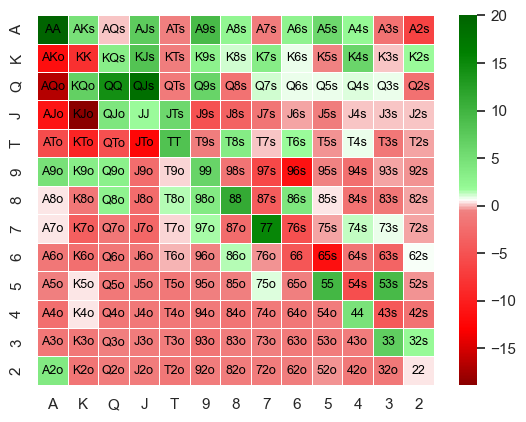

In [65]:
sns.heatmap(df_winnings_by_combo.rename_axis(index=None, columns=None), cmap=cmap, linewidth=.5, annot=combos_df, fmt='', annot_kws={'size': 9, 'color':'black'})